<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/09_mf_keras_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'
#df = pd.read_csv(BASE_PATH+'edited_rating.csv')
df = pd.read_csv(BASE_PATH+'very_small_rating.csv')
pd.options.display.float_format = '{:.2f}'.format
df.info()
display(df.describe())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982718 entries, 0 to 1982717
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   movie_idx  int64  
dtypes: float64(1), int64(3)
memory usage: 60.5 MB


,userId,movieId,rating,movie_idx
count,1982718.00,1982718.00,1982718.00,1982718.00
mean,1796.93,5116.48,3.47,417.32
std,1164.18,11798.80,1.00,287.50
min,0.00,1.00,0.50,0.00
25%,765.00,1029.00,3.00,162.00
50%,1703.00,1997.00,3.50,379.00
75%,2776.00,3578.00,4.00,651.00
max,3999.00,81845.00,5.00,999.00


,userId,movieId,rating,movie_idx
0,3863,1,4.00,10
1,3863,2,3.00,125
2,3863,5,3.00,359
3,3863,6,3.00,104
4,3863,10,4.00,68
...,...,...,...,...
1982713,3457,74458,3.50,846
1982714,3457,78499,4.00,860
1982715,3457,79132,4.50,287
1982716,3457,80463,4.00,954


In [3]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [4]:
# split into train and test
#df = df.sample(frac=0.1, random_state=42)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0)

In [5]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 20

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        40000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        10000       ['input_2[0][0]']                
                                                                                              

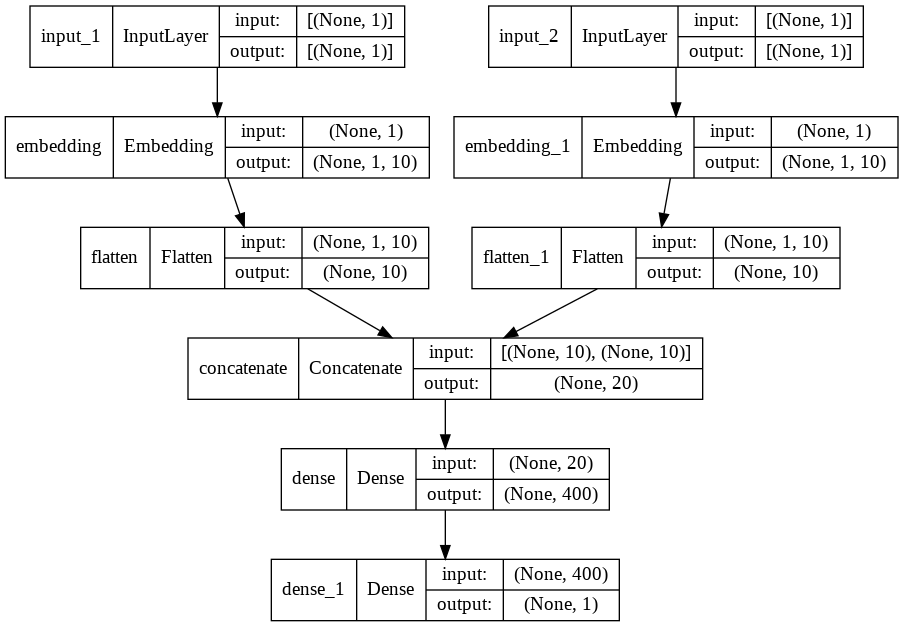

In [6]:
u = tf.keras.layers.Input(shape=(1,))
m = tf.keras.layers.Input(shape=(1,))
u_embedding = tf.keras.layers.Embedding(N, K)(u) # (N, 1, K)
m_embedding = tf.keras.layers.Embedding(M, K)(m) # (N, 1, K)
u_embedding = tf.keras.layers.Flatten()(u_embedding) # (N, K)
m_embedding = tf.keras.layers.Flatten()(m_embedding) # (N, K)
x = tf.keras.layers.Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = tf.keras.layers.Dense(400, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(100)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9),
  metrics=['mse'],
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
%%time
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  ),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/15
12392/12392 [==============================] - 68s 5ms/step - loss: 0.6723 - mse: 0.6723 - val_loss: 0.6536 - val_mse: 0.6536
Epoch 2/15
12392/12392 [==============================] - 66s 5ms/step - loss: 0.6293 - mse: 0.6293 - val_loss: 0.6240 - val_mse: 0.6240
Epoch 3/15
12392/12392 [==============================] - 65s 5ms/step - loss: 0.6163 - mse: 0.6163 - val_loss: 0.6149 - val_mse: 0.6149
Epoch 4/15
12392/12392 [==============================] - 66s 5ms/step - loss: 0.6034 - mse: 0.6034 - val_loss: 0.6036 - val_mse: 0.6036
Epoch 5/15
12392/12392 [==============================] - 71s 6ms/step - loss: 0.5971 - mse: 0.5971 - val_loss: 0.5956 - val_mse: 0.5956
Epoch 6/15
12392/12392 [==============================] - 71s 6ms/step - loss: 0.5896 - mse: 0.5896 - val_loss: 0.6127 - val_mse: 0.6127
Epoch 7/15
12392/12392 [==============================] - 70s 6ms/step - loss: 0.5825 - mse: 0.5825 - val_loss: 0.5928 - val_mse: 0.5928
Epoch 8/15
12392/12392 [=================

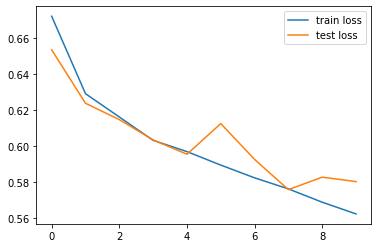

In [8]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

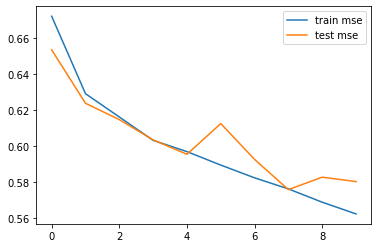

In [9]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()